# Week 2: Dynamic Programming
### Authored by: Mithun Vanniasinghe

Welcome to week 2 of the UTMIST RL Workshop. This notebook will be an exercise in implementing the dynamic programming methods discussed in the slides. You will perform the following algorithms on a 4x4 gridworld example similar to the one from the slides:

1. Iterative Policy Evaluation
2. Policy Iteration
3. Value Iteration


In [ ]:
!git clone https://github.com/UTMIST/rl-workshop


fatal: destination path 'rl-workshop' already exists and is not an empty directory.


In [ ]:
!mv /content/rl-workshop/Week\ 2 /content/enviroment

mv: cannot stat '/content/rl-workshop/Week 2': No such file or directory


In [ ]:
import numpy as np # python library for dealing with arrays
from enviroment.gridworld import GridWorld # custom grid world enviroment written by Jessica
import tqdm # to show progress bar
import matplotlib.pyplot as plt
import seaborn as sns

import importlib



Let's recall what the gridworld looks like first:


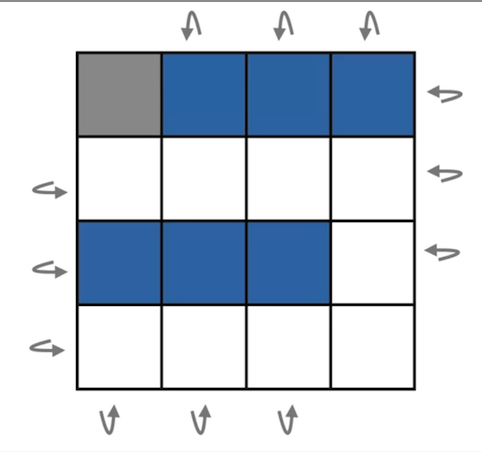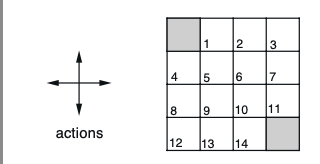

It is a 4x4 world with states 0 being  a terminal state. You get a reward of -1 on all transitions except when you transition to the terminal state which recieves a reward of zero and when you transition to the blue states where tou get a reward of -10. You have a choice between 4 options, **North**, **South**, **East**, or **West**. If you try to move off the grid, you stay in the same state and also get a reward of -1.

Whenever you take an action from any state, the probability of actually doing what your choice of action intends to do is 0.7 and the probabilty of ending up doing one of the other actions is 0.1 each.

For example, if you are in state 11 and try going East,

$$
p(s', r | s=11, a=\text{East}) = p(s' | s=11, a=\text{East}) \quad \text{(since reward is given deterministically here)}
$$

This results in:

- $p(s' = 11) = 0.7$
- $p(s' = 7) = 0.1$
- $p(s' = 10) = 0.1$
- $p(s' = 15) = 0.1$

## Part 1: Iterative Policy Evaluation

### Background Info

Iterative Policy Evaluation aims to iteratively find the value function under a given policy. Recall the Bellman Equation:

The Bellman expectation equation can be expressed as:

$$
V_{\pi}(s) = \sum_{a} \pi(a | s) \sum_{s', r} P(s', r | s, a) \left( r + \gamma V_{\pi}(s') \right)
$$

Where:
- $V_{\pi}(s)$ is the value of state $s$ under policy $\pi$.
- $\pi(a | s)$ is the probability of taking action $a$ in state $s$ according to policy $\pi$.
- $P(s', r | s, a)$ is the probability of reaching state $s'$ and receiving reward $r$ from state $s$ after taking action $a$.
- $\gamma$ is the discount factor (a value between 0 and 1).


These are actually a set of $|S|$ linear equations in $|S|$ unknowns where |S| is the magnitude of the state space. For example, in a state space of size 4 and under a determinsitc policy and reward the system of equations would look like this:


\begin{align*}
V(s_0) &= R(s_0) + \gamma \left( P(s_0 | s_0, a_0) V(s_0) + P(s_1 | s_0, a_0) V(s_1) + P(s_2 | s_0, a_0) V(s_2) + P(s_3 | s_0, a_0) V(s_3) \right) \\
V(s_1) &= R(s_1) + \gamma \left( P(s_0 | s_1, a_1) V(s_0) + P(s_1 | s_1, a_1) V(s_1) + P(s_2 | s_1, a_1) V(s_2) + P(s_3 | s_1, a_1) V(s_3) \right) \\
V(s_2) &= R(s_2) + \gamma \left( P(s_0 | s_2, a_2) V(s_0) + P(s_1 | s_2, a_2) V(s_1) + P(s_2 | s_2, a_2) V(s_2) + P(s_3 | s_2, a_2) V(s_3) \right) \\
V(s_3) &= R(s_3) + \gamma \left( P(s_0 | s_3, a_3) V(s_0) + P(s_1 | s_3, a_3) V(s_1) + P(s_2 | s_3, a_3) V(s_2) + P(s_3 | s_3, a_3) V(s_3) \right)
\end{align*}


Our gridworld would be a system of 15 linear equations in 15 unkowns.As the size of the state space grows these equations become hard to solve via linear algebra and we must rely on iterative methods.


### The Algorithm

Using iterative policy evaluation and given a policy $\pi$ we can iterativley update the value function starting from an arbritary initialization. Theorems from real analysis gaurentee converge of $V_{k} = V_{\pi}$ as this is a fixed point of the Bellman Equation Update Rule:


$$
V_{k+1}(s) = \sum_{a} \pi(a | s) \sum_{s', r} P(s', r | s, a) \left( r + \gamma V_k(s') \right)
$$




The policy that we will use to for evaluation is the uniform random policy. Each direction, North, South, East, or West has an equal probabilty of being chosen of 25% from all states

Actions are indexed using 0,1,2 and 3 for North, East, South, and West respectively

#### Let's initialize a policy (uniform to start out) and the enviroment

In [ ]:

env = GridWorld()

# Set the width of the grid
# The total number of states is the square of the width (n)
# In this case, there are 4 cols since there are 4 possible actions
policy = 0.25 * np.ones((env.n ** 2, 4))
print("Initialized Policy (Uniform Distribution):")
print(policy)


# To find the transition probabilities given the current state and action,
# you can call the following method:
# env.transitions(state, action)

# For example, if you are in state 11 and attempt to move east (action 1):
env.transitions(11, 1)
env.reward_grid

# This returns a 2D array in the format:
# [[s', r, probability]
#  [s', r, probability]
#    ...
#  [s', r, probability]]

# Where:
# - s' is the next state
# - r is the reward received
# - probability is the likelihood of reaching the next state

Initialized Policy (Uniform Distribution):
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


array([[  0., -10., -10., -10.],
       [ -1.,  -1.,  -1.,  -1.],
       [-10., -10., -10.,  -1.],
       [ -1.,  -1.,  -1.,  -1.]])

Recall the Policy evaluation is given by the following algorithm. Is it your task to perform the bellman update:

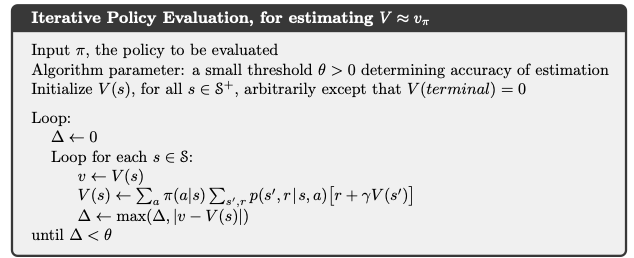

In [ ]:
def bellman_update(env, value_func, policy, state, gamma):
  '''
  Args:
    env: the enviroment
    value_func: 1D array that holds the value of each state
    policy: 2D array that holds that policy for each state(row) and for each action (col)
    state: current state we want to do the update for
    gamma: discount factor for the Markov Descision Process

  Return:
    None - mutate the value function passed in
  '''
  # TODO: implement this funciton that does the iterative bellman update
  # HINT: use env.transitions to get the transition probabilites
  # HINT: you might need 2 loops
  temp = 0
  for action_idx, action_prob in enumerate(policy[state]):
    transitions = env.transitions(state, action_idx)
    # print(transitions, action_idx)
    for transition in transitions:
      next_state, reward, prob = transition  # Unpacking the transition
      temp += action_prob * prob*(reward + gamma* value_func[int(next_state)])

  value_func[state] = temp


In [ ]:
def eval_policy(env, policy, theta, gamma, value_func=None):
  '''
  Does the policy eval algorithm
  Args:
    env: the enviroment
    policy:  2D array that holds that policy for each state(row) and for each action (col)
    theta: an accuracy threshold (closer to 0 means we want a more accurate value function, closer to the true value)
    gamma: discoutn factor of the Markov Decision Process

  Return:
    value_func: the computed value func
  '''
  delta = float('inf') # init to a large number
  num_states = env.n ** 2 # number of states in grid world

  # Note, for policy evaluation, Value function is randomly init, we include this here so the code can be reused for policy iteration
  if value_func is  None: # if value func is not given, do init
    value_func = np.zeros(num_states) # init to zeros


  while delta > theta: # stop when error gets to an accepted accuracy
    delta = 0 # init difference to be zero at start of eval
    for state in range(num_states):
      value = value_func[state] # get the current value function of at state
      bellman_update(env, value_func, policy, state, gamma) # perform the bellman update for the current state
      delta = max(delta, abs(value - value_func[state])) # keep track of the largest error
  return value_func # return once we have reached an acceptable accuracy

values = eval_policy(env, policy, 0.0001, 1)

Text(0.5, 1.0, 'Value Function Heatmap')

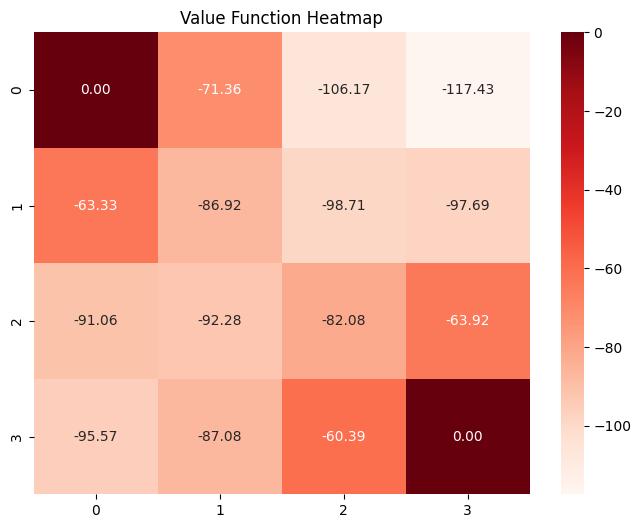

In [ ]:
# Plotting the value of each state, notice states closer to the terminal states have higher value (want to transition to terminal states faster to maximize reward)
value_grid = values.reshape((4, 4)) # reshape into 4x4 grid
plt.figure(figsize=(8, 6))
sns.heatmap(value_grid, annot=True, fmt=".2f", cmap="Reds", cbar=True,
            xticklabels=np.arange(4), yticklabels=np.arange(4))
plt.title("Value Function Heatmap")

#### Does this make intituive sense?

Recall, you get a reward of -1 in the white states, -10 in the blue states, and 0 at the terminal states. Under our uniform policy, how does the value of these different types of states compare?

## Part 2: Policy Iteration

Policy iteration looks at the task of control. The aim is to try and learn optimal policy. It involves two steps.

1. Policy Evaluation
2. Policy Improvement

Given an intial arbritary value function and policy we alternate between policy evaluation and policy improvement.

We evaluate the value function under the current policy for each state using the policy evaluation algorithm from part 1 and then improve the policy by acting greedily via the Bellman optimality equation for value functions.

$$
V^{*}(s) = \max_{a} \sum_{s', r} P(s' | s, a) \left( r + \gamma V^{*}(s') \right)
$$

In each step, choose the action that achieves this maximum value. We repeat this back and forth process until the policies no longer change for all states.

A good visual is the following. You are being greedy with your policy selection, each time making your policy a bit better with respect to the current value function. The your value function gets updated based on your new policy, Eventually, you will converge to the optimal policy and the associated optimal value function:

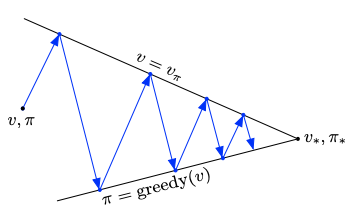

The pseudocode for the algorithm is below:
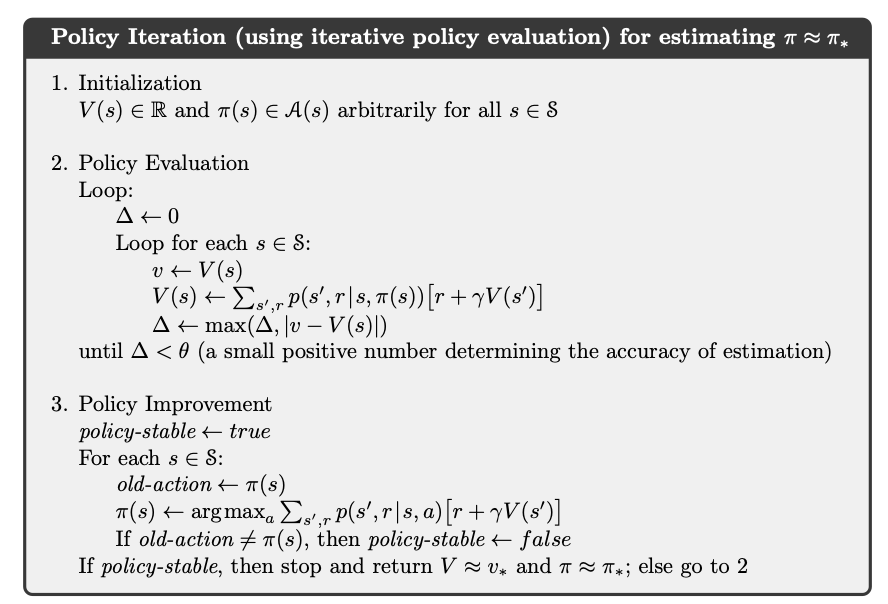


In [ ]:
def policy_improvement(env, value_func, policy, gamma):
  policy_stable = True # init the policy to be unchanged (stable)
  num_states = env.n **2 # num states is the grid world size squared
  for state in range(num_states):
    old_policy = policy[state].copy() # keep track of old policy at current state to compare
    choose_greedy_action(env, state, policy, value_func, gamma) # perform a greedy update
    if not np.array_equal(policy[state], old_policy): # check if policy has changed for current state, if it has the policy is not yet stable
      policy_stable = False

  return policy, policy_stable

def choose_greedy_action(env, state, policy, value_func, gamma):
   # TODO: implement a greedyy policy update
   # HINT: you need to keep track of the best actions and best values
   # HINT: the terminal cases need to be handled specially, what are the probabilties of taking any action from a terminal state?
   # HINT: This funtion should update the policy[state] for which it was called on in the policy_improvement function
  best_action = None # keep track of the best action
  best_val = float('-inf') # min for the best value
  num_actions = policy.shape[1]

  if state in env.terminal_states:
    policy[state] = np.zeros(num_actions) # if state it terminal, we can't take anymore actions, assigned zero probabilty to all actions (taking an action is meaningless from a terminal state)
    return

  # perform an argmax over all actions
  for action in range(num_actions):
    transitions = env.transitions(state, action)
    value = 0
    # compute value functions for each action
    for transition in transitions:
      next_state, reward, prob = transition
      next_state = int(next_state)
      value += prob *(reward + gamma * value_func[next_state]) # compute value function for this action

    if value > best_val: # if this value is better than previous, hold on to the associated value and action
      best_val = value
      best_action = action

  policy[state] = [1 if i == best_action else 0 for i in range(len(policy[state]))] # assign the policy to have probabilty 1 for the best action


In [ ]:
def policy_iteration(env, gamma, theta):
  n_states = env.n ** 2 # num states is size of grid world squared
  n_actions = 4
  value_func = np.zeros(n_states) # init value function to all zeros
  policy = np.random.rand(n_states, n_actions) # init a random policy
  policy = policy / policy.sum(axis=1, keepdims=True) # init a random policy (sum over and divide to make sure it is a proper probability dist)
  policy_stable = False

  while policy_stable == False: # go back and forth between policy eval and policy improvement
    value_func = eval_policy(env, policy, theta, gamma, value_func)
    policy, policy_stable = policy_improvement(env, value_func, policy, gamma)

  return policy, value_func




In [ ]:
# try out an example!
policy, value_func = policy_iteration(env, gamma=0.9, theta=0.1)

In [ ]:
# print out the policy, does this look reasonable
policy

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

## Plotting the Optimal Policy

Run the below cells to plot the policy, see if it makes sense if we want to make as much reward as possible!

In [ ]:
action_directions = {
    0: '↑',  # North
    1: '→',  # East
    2: '↓',  # South
    3: '←'   # West
}

In [ ]:
def get_arrow(prob_arr):
    """Returns the arrows that represent the highest probability actions.

    Args:
        prob_arr (array): numpy array denoting the probability of taking each action on a given state

    Returns:
        arrow (str): string denoting the most probable action(s)
    """

    best_actions = np.where(prob_arr == np.amax(prob_arr))[0]
    if len(best_actions) == 1:
        if 0 in best_actions:
            return r"$\uparrow$"
        if 1 in best_actions:
            return r"$\rightarrow$"
        if 2 in best_actions:
            return r"$\downarrow$"
        if 3 in best_actions:
            return r"$\leftarrow$"
    else:
      return None



In [ ]:
def plot_optimal_actions(env, pi):
    from matplotlib import colors
    """Plots the optimal action to take in each state

    Args:
        env (Environment): grid world environment
        pi (array): numpy array indicating the probability of taking each action in each state
    """
    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(env.reward_grid, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(env.n):
        for j in range(env.n):
            state = env.state((i,j))
            arrow = get_arrow(pi[state])
            if arrow is not None:
              text = ax.text(j, i, arrow, fontsize=16, ha="center", va="center", color="black")
            else:
              pass

    ax.set_title("Policy")
    fig.tight_layout()
    plt.show()

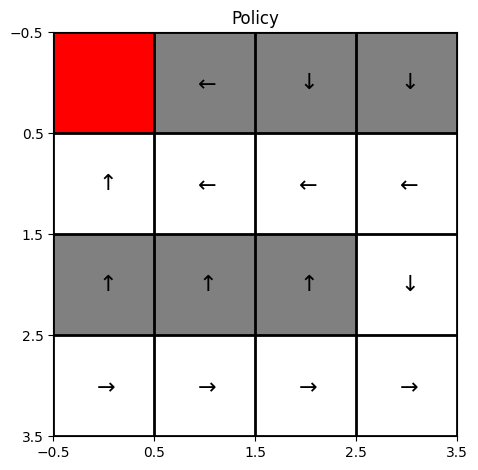

In [ ]:
plot_optimal_actions(env, policy)

Check with the value function to see if these values make sense!

Text(0.5, 1.0, 'Value Function Heatmap')

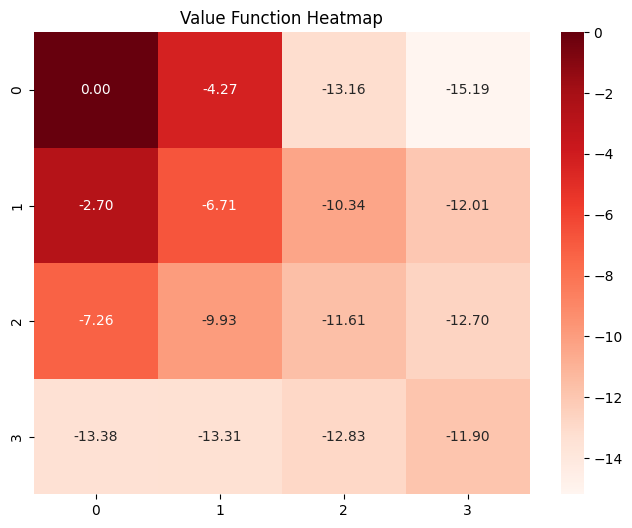

In [ ]:
# Plotting the value of each state, notice states closer to the terminal states have higher value (want to transition to terminal states faster to maximize reward)
value_grid = value_func.reshape((4, 4)) # reshape into 4x4 grid
plt.figure(figsize=(8, 6))
sns.heatmap(value_grid, annot=True, fmt=".2f", cmap="Reds", cbar=True,
            xticklabels=np.arange(4), yticklabels=np.arange(4))
plt.title("Value Function Heatmap")

# Part 3: Value Iteration

Value iteration will be a take home exercise, it is very similar to the policy iteration algorithm except it combines the evaluation and improvement step into 1! Try and see if you can replicate the results from policy iteration